# MaxEnt Large Testing Notebook

This notebook validates the new `calibrated_response.maxent_large` path with quick, deterministic sanity checks:
- `PersistentBuffer` initialization and sampling behavior
- MCMC state-domain validity and shape checks
- End-to-end `DistributionBuilder` smoke test with supported + skipped constraints
- Basic training diagnostics (`max_error`, `mean_error`)


In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from calibrated_response.maxent_large.graph import SMMVariable, Factor, build_graph
from calibrated_response.maxent_large.mcmc.buffer import PersistentBuffer
from calibrated_response.maxent_large.distribution_builder import DistributionBuilder
from calibrated_response.maxent_large.training import SMMConfig

from calibrated_response.models.variable import ContinuousVariable, BinaryVariable
from calibrated_response.models.query import (
    ProbabilityEstimate,
    ExpectationEstimate,
    ConditionalProbabilityEstimate,
    ConditionalExpectationEstimate,
    InequalityProposition,
    EqualityProposition,
)

def assert_true(condition: bool, message: str) -> None:
    if not condition:
        raise AssertionError(message)


## 1) PersistentBuffer unit-style checks

Build a tiny factor graph with one binary and one ternary variable, then validate `PersistentBuffer` properties.

In [2]:
# Small graph: var0 in {0,1}, var1 in {0,1,2}
variables = [
    SMMVariable(name="a", kind="categorical", num_states=2),
    SMMVariable(name="b", kind="categorical", num_states=3),
]

# Unary factors + one pairwise factor with slight preference for aligned low states
factors = [
    Factor(id=0, var_ids=(0,), theta=jnp.array([0.0, 0.2], dtype=jnp.float32), table_shape=(2,)),
    Factor(id=1, var_ids=(1,), theta=jnp.array([0.2, 0.0, -0.1], dtype=jnp.float32), table_shape=(3,)),
    Factor(
        id=2,
        var_ids=(0, 1),
        theta=jnp.array([[0.4, 0.1, -0.1], [0.0, 0.1, 0.2]], dtype=jnp.float32),
        table_shape=(2, 3),
    ),
]
graph = build_graph(variables, factors)

seed = 123
num_chains = 16
buf0 = PersistentBuffer.initialize(graph, num_chains=num_chains, rng_key=jax.random.PRNGKey(seed))
states0 = np.asarray(buf0.get_states())

assert_true(states0.shape == (num_chains, 2), f"Unexpected initial shape: {states0.shape}")
assert_true(np.all((states0[:, 0] >= 0) & (states0[:, 0] < 2)), "Var a out of bounds at init")
assert_true(np.all((states0[:, 1] >= 0) & (states0[:, 1] < 3)), "Var b out of bounds at init")

buf1 = buf0.sample_step(graph, n_sweeps=4, temperature=1.0)
states1 = np.asarray(buf1.get_states())
assert_true(states1.shape == states0.shape, "Shape changed after sampling")
assert_true(np.all((states1[:, 0] >= 0) & (states1[:, 0] < 2)), "Var a out of bounds after sampling")
assert_true(np.all((states1[:, 1] >= 0) & (states1[:, 1] < 3)), "Var b out of bounds after sampling")

changed = np.any(states1 != states0)
print("Initial states shape:", states0.shape)
print("Any state changed after 4 sweeps:", bool(changed))
print("Buffer checks passed.")


Initial states shape: (16, 2)
Any state changed after 4 sweeps: True
Buffer checks passed.


## 2) End-to-end builder smoke test

This mirrors the pytest smoke path and confirms marginals are normalized and skipped constraints are surfaced.

In [3]:
variables = [
    ContinuousVariable(
        name="x",
        description="Target",
        lower_bound=0.0,
        upper_bound=1.0,
        unit="u",
    ),
    BinaryVariable(name="rain", description="Whether it rains"),
]

estimates = [
    ProbabilityEstimate(
        id="p_x_gt",
        proposition=InequalityProposition(
            variable="x",
            variable_type="continuous",
            threshold=0.4,
            is_lower_bound=True,
        ),
        probability=0.7,
    ),
    ExpectationEstimate(id="e_x", variable="x", expected_value=0.55),
    ConditionalProbabilityEstimate(
        id="cp_rain",
        proposition=InequalityProposition(
            variable="x",
            variable_type="continuous",
            threshold=0.6,
            is_lower_bound=True,
        ),
        conditions=[EqualityProposition(variable="rain", variable_type="binary", value=True)],
        probability=0.75,
    ),
    # Unsupported by adapter on purpose: should appear in skipped_constraints
    ConditionalExpectationEstimate(
        id="ce_unsupported",
        variable="x",
        conditions=[EqualityProposition(variable="rain", variable_type="binary", value=False)],
        expected_value=0.2,
    ),
]

cfg = SMMConfig(
    num_iterations=20,
    num_chains=32,
    mcmc_steps_per_iteration=2,
    max_bins=12,
    seed=7,
)
builder = DistributionBuilder(variables=variables, estimates=estimates, solver_config=cfg)

distribution, info = builder.build(target_variable="x")

probs = np.asarray(distribution.bin_probabilities, dtype=float)
assert_true(len(probs) == 12, f"Expected 12 bins, got {len(probs)}")
assert_true(np.isclose(probs.sum(), 1.0, atol=1e-6), f"Target marginal not normalized: {probs.sum()}")
assert_true(any("conditional expectation unsupported" in s for s in info["skipped_constraints"]),
            "Expected unsupported conditional expectation to be reported")

all_marginals = builder.get_all_marginals(info)
assert_true(set(all_marginals.keys()) == {"x", "rain"}, f"Unexpected marginals keys: {all_marginals.keys()}")

print("Target variable:", info["target_variable"])
print("Factors used:", info["n_factors"])
print("Skipped constraints:", info["skipped_constraints"])
print("Builder smoke checks passed.")


Target variable: x
Factors used: 3
Skipped constraints: ['ce_unsupported: conditional expectation unsupported in v1']
Builder smoke checks passed.


## 3) Training diagnostics quick look

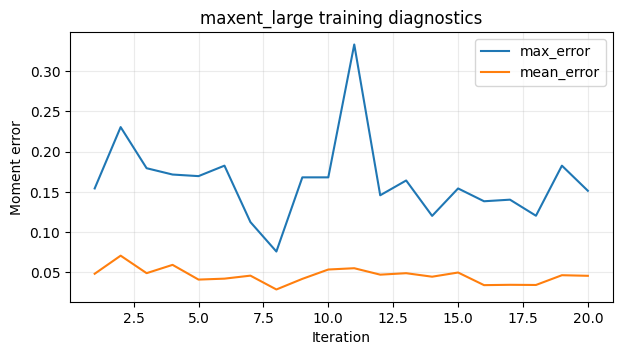

Final max error: 0.1514110267162323
Final mean error: 0.04570520296692848


In [4]:
history = info["history"]
iters = history["iteration"]
max_err = history["max_error"]
mean_err = history["mean_error"]

assert_true(len(iters) == cfg.num_iterations, "History iterations do not match config")
assert_true(len(max_err) == cfg.num_iterations, "max_error length mismatch")
assert_true(len(mean_err) == cfg.num_iterations, "mean_error length mismatch")

plt.figure(figsize=(7, 3.5))
plt.plot(iters, max_err, label="max_error")
plt.plot(iters, mean_err, label="mean_error")
plt.xlabel("Iteration")
plt.ylabel("Moment error")
plt.title("maxent_large training diagnostics")
plt.legend()
plt.grid(alpha=0.25)
plt.show()

print("Final max error:", float(max_err[-1]))
print("Final mean error:", float(mean_err[-1]))


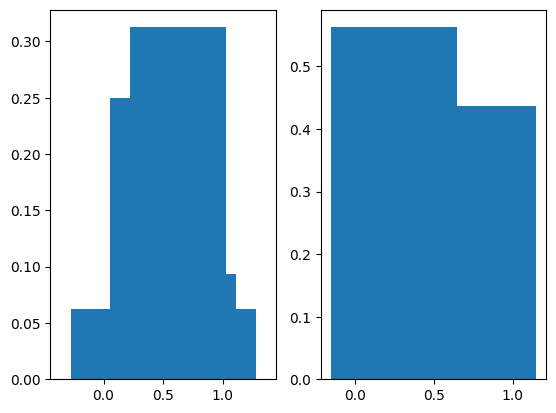

In [9]:
fig, ax = plt.subplots(1, len(all_marginals))
for i, (k, hd) in enumerate(all_marginals.items()):
    
    ax[i].bar((np.array(hd.bin_edges[1:]) + np.array(hd.bin_edges[:-1]))/2, hd.bin_probabilities)
fig.show(0)